In [1]:
import pandas as pd
import numpy as np
import requests
import plotly.express as px

In [2]:
DATA_URL = "https://ws.dim.gov.az/wa_open_data/api/json/n12_1_7"

payload = requests.get(DATA_URL).json()

list(payload.keys())

['Ali təhsil müəssisələrinin qəbul planları']

In [3]:
dfs = {k: pd.DataFrame(v) for k, v in payload.items()}

for name, df in dfs.items():
    print(name, df.shape)
    display(df.head())

Ali təhsil müəssisələrinin qəbul planları (45, 7)


,Ali təhsil müəssisəsi,Azərbaycan bölməsinin abituriyentləri üçün,Rus bölməsinin abituriyentləri üçün,Hər iki bölmənin abituriyentlərinin birgə müsabiqəsi üçün,Cəmi,İl,Daxiledilmə tarixi
0,Bakı Dövlət Universiteti,4821.0,705.0,590.0,6116.0,2024.0,2025-05-14T12:46:00
1,Azərbaycan Dövlət Neft və Sənaye Universiteti,2875.0,215.0,715.0,3805.0,2024.0,2025-05-14T12:46:00
2,Azərbaycan Texniki Universiteti,955.0,0.0,1689.0,2644.0,2024.0,2025-05-14T12:46:00
3,Azərbaycan Memarlıq və İnşaat Universiteti,1710.0,155.0,605.0,2470.0,2024.0,2025-05-14T12:46:00
4,Azərbaycan Tibb Universiteti,833.0,130.0,10.0,973.0,2024.0,2025-05-14T12:46:00


In [4]:
admissions = dfs[[k for k in dfs.keys() if "qəbul plan" in k.lower() or "qebul plan" in k.lower()][0]].copy()

admissions = admissions[~admissions.iloc[:,0].astype(str).str.contains("C", na=False)]

rename_map = {
    "Ali təhsil müəssisəsi": "University",
    "Azərbaycan bölməsinin abituriyentləri üçün": "Seats_AZ",
    "Rus bölməsinin abituriyentləri üçün": "Seats_RU",
    "Hər iki bölmənin abituriyentlərinin birgə müsabiqəsi üçün": "Seats_Mixed",
    "Cəmi": "Seats_Total",
    "İl": "Year",
    "Daxiledilmə tarixi": "Inserted_At",
}
admissions = admissions.rename(columns={k:v for k,v in rename_map.items() if k in admissions.columns})

num_cols = [c for c in admissions.columns if c.startswith("Seats_")]
for c in num_cols:
    admissions[c] = pd.to_numeric(admissions[c], errors="coerce")

admissions["Share_RU"] = admissions["Seats_RU"] / admissions["Seats_Total"]
admissions["Share_Mixed"] = admissions["Seats_Mixed"] / admissions["Seats_Total"]

admissions.sort_values("Seats_Total", ascending=False).head(10)


,Ali təhsil müəssisəsi,Seats_AZ,Seats_RU,Seats_Mixed,Seats_Total,Year,Inserted_At,Share_RU,Share_Mixed
0,Bakı Dövlət Universiteti,4821.0,705.0,590.0,6116.0,2024.0,2025-05-14T12:46:00,0.115271,0.096468
6,Azərbaycan Dövlət İqtisad Universiteti,3370.0,530.0,255.0,4155.0,2024.0,2025-05-14T12:46:00,0.127557,0.061372
1,Azərbaycan Dövlət Neft və Sənaye Universiteti,2875.0,215.0,715.0,3805.0,2024.0,2025-05-14T12:46:00,0.056505,0.187911
5,Azərbaycan Dövlət Pedaqoji Universiteti,3334.0,270.0,145.0,3749.0,2024.0,2025-05-14T12:46:00,0.072019,0.038677
2,Azərbaycan Texniki Universiteti,955.0,0.0,1689.0,2644.0,2024.0,2025-05-14T12:46:00,0.000000,0.638805
3,Azərbaycan Memarlıq və İnşaat Universiteti,1710.0,155.0,605.0,2470.0,2024.0,2025-05-14T12:46:00,0.062753,0.244939
9,Bakı Mühəndislik Universiteti,1760.0,0.0,525.0,2285.0,2024.0,2025-05-14T12:46:00,0.000000,0.229759
31,Lənkəran Dövlət Universiteti,2055.0,0.0,0.0,2055.0,2024.0,2025-05-14T12:46:00,0.000000,0.000000
27,Gəncə Dövlət Universiteti,1758.0,15.0,15.0,1788.0,2024.0,2025-05-14T12:46:00,0.008389,0.008389
26,Azərbaycan Dövlət Aqrar Universiteti,1520.0,180.0,75.0,1775.0,2024.0,2025-05-14T12:46:00,0.101408,0.042254


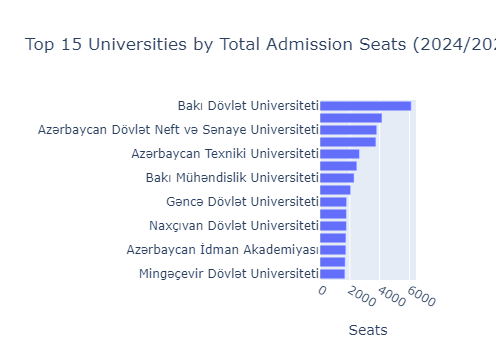

In [6]:
top = admissions.sort_values("Seats_Total", ascending=False).head(15)

fig = px.bar(
    top.sort_values("Seats_Total"),
    x="Seats_Total",
    y="Ali təhsil  müəssisəsi",
    orientation="h",
    title="Top 15 Universities by Total Admission Seats (2024/2025)"
)
fig.update_layout(xaxis_title="Seats", yaxis_title="")
fig.show()

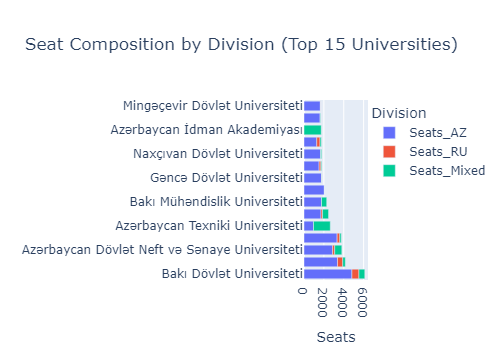

In [10]:
melted = top.melt(
    id_vars=["Ali təhsil  müəssisəsi"],
    value_vars=["Seats_AZ","Seats_RU","Seats_Mixed"],
    var_name="Division",
    value_name="Seats"
)

fig = px.bar(
    melted,
    x="Seats",
    y="Ali təhsil  müəssisəsi",
    color="Division",
    orientation="h",
    title="Seat Composition by Division (Top 15 Universities)"
)
fig.update_layout(xaxis_title="Seats", yaxis_title="")
fig.show()